<a href="https://colab.research.google.com/github/yeahzee0421/AI_2022/blob/main/%EC%8B%9C%ED%80%80%EC%8A%A4%ED%8C%A8%ED%84%B4%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

#keras : 유저가 손쉽게 딥러닝 구현할 수 있도록 도와주는 상위 레벨의 인터페이스. 딥러닝 구현 쉽게 해준다.
import keras
# 모델링
# sequential() : 인공 신경망에서 사용되는 입력층, 은닉층, 출력층을 구성하기 위한 메소드.
from keras.models import Sequential 
#Dense : 층 추가.
#파라미터 - 출력 뉴런의 수, 입력 뉴런의 수(입력의 차원), 활성화 함수
# sigmoid : 이진 분류 문제에서 출력층에 주로 사용되는 활성화 함수.
# softmax : 셋 이상의 선택지 중 하나를 택하는 다중 클래스 분류 문제에서 출력층에 주로 사용되는 활성화 함수.
# relu : 은닉층에 주로 사용되는 활성화 함수.

#은닉층 이외에도 LSTM, GRU, Conv2D, BatchNormalization... 다양한 층 생성 가능. 

from keras.layers import Dense, Dropout, Flatten, Reshape, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, GlobalAveragePooling1D
#GlobalAveragePooling1D : 고정된 크기의 출력 벡터 리턴. 
from keras.utils import np_utils
%config InlineBackend.figure_format = 'retina'

# Flatten vs GlobalAveragePooling vs Max Pooling



*  **Flatten**


> 모든 모양의 텐서 가져와 1차원 텐서로 변환, 모든 값은 텐서에 유지시킴. ex: (샘플,10,20,1) --> (샘플, 10 * 20 * 1)로 평면화!  
하지만 보통 많은 매개 변수가 쓰인다.

*  **Global Average Pooling 2D**

> 텐서 모양이 여전히 크다면 Flatten 대신 Global Average Pooling 2D 계층 사용 선호. 과적합 중인 경우 시도 가능.
--> 벡터를 더 잘 표현하기 위해 사용되는 방법론 


> 모델의 총 매개변수를 줄여 과적합 최소화.
GAP 레이어는 3차원 텐서의 공간차원 줄이는 데 사용. 

*   **Pooling (=sub sampling)**

> sub sampling : 해당하는 image data를 작은 사이즈의 image로 줄이는 과정.


> CNN 기준으로 pooling은 conv layer와 activation을 거쳐 나온 결과인 activation feature map에 대하여 기술 적용. resizing을 통해 새로운 층을 얻는다. 


> ***Why do we Use Pooling?***

>앞선 레이어들을 거치고 나온 output feature map의 모든 data가 필요하지 않다. 즉, 결과를 추론하는데 있어 적당량의 data만 있어도 됨. 


[ref](https://koreapy.tistory.com/603)

In [2]:
!curl https://raw.githubusercontent.com/StillWork/data/master/smartphone_human.txt.zip\
    -o smartphone_human.txt.zip
# !curl -L https://bit.ly/36LsyVs -o smartphone_human.txt.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.5M  100 10.5M    0     0  27.4M      0 --:--:-- --:--:-- --:--:-- 27.4M


In [3]:
!unzip -o smartphone_human.txt.zip

Archive:  smartphone_human.txt.zip
  inflating: smartphone_human.txt    
   creating: __MACOSX/
  inflating: __MACOSX/._smartphone_human.txt  


In [4]:
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']

In [5]:
!head -5 smartphone_human.txt

33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286;
33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172;
33,Jogging,49106332290000,-1.1849703,12.108489,7.205164;


DF 형태로 만들어준다. 

In [7]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 
                'y-axis', 'z-axis']
df = pd.read_csv('smartphone_human.txt', header=None, names=column_names)
df[:2]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x-axis     1098204 non-null  float64
 4   y-axis     1098204 non-null  float64
 5   z-axis     1098203 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 50.3+ MB


In [9]:
df['z-axis'].replace(regex=True,inplace=True, to_replace=r';', value=r'') #끝에 쉼표 없애주고 
df['z-axis'] = df['z-axis'].apply(np.float) #float 형태로 형 맞춰주기. 
df.dropna(axis=0, how='any', inplace=True)

<ipython-input-9-d3664e294e6d>:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df['z-axis'] = df['z-axis'].apply(np.float)


In [10]:
df[:3]

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722


In [12]:
df.isnull().sum() #결측값 파악 --> 없음. 

user-id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64

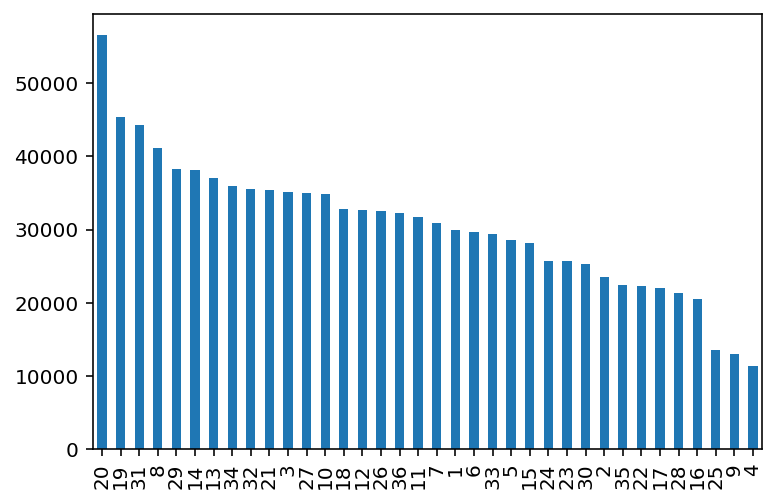

In [17]:
df['user-id'].value_counts().plot(kind='bar')

In [18]:
#nunique() : 데이터 고유값의 총 수 출력. 
df['user-id'].nunique() 

36

In [19]:
df['activity'].value_counts()

Walking       424397
Jogging       342176
Upstairs      122869
Downstairs    100427
Sitting        59939
Standing       48395
Name: activity, dtype: int64

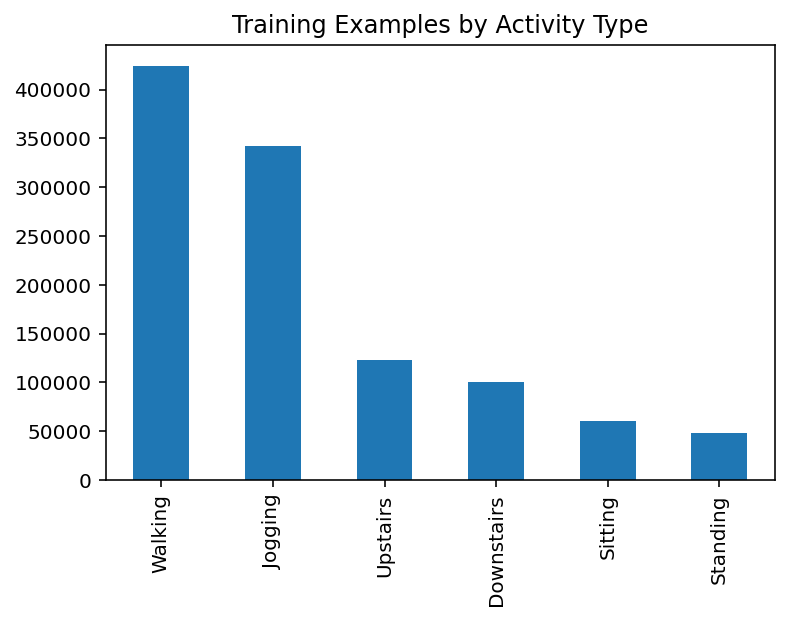

In [20]:
df['activity'].value_counts().plot(kind='bar', title="Training Examples by Activity Type")
plt.show()

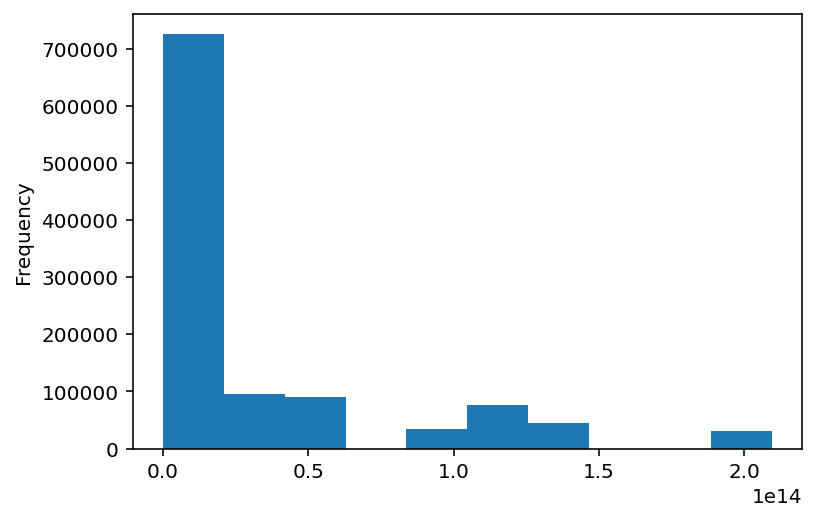

In [21]:
df['timestamp'].plot(kind='hist')

In [27]:
df=df[df['timestamp'] > 0]
np.unique(df['activity'])

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

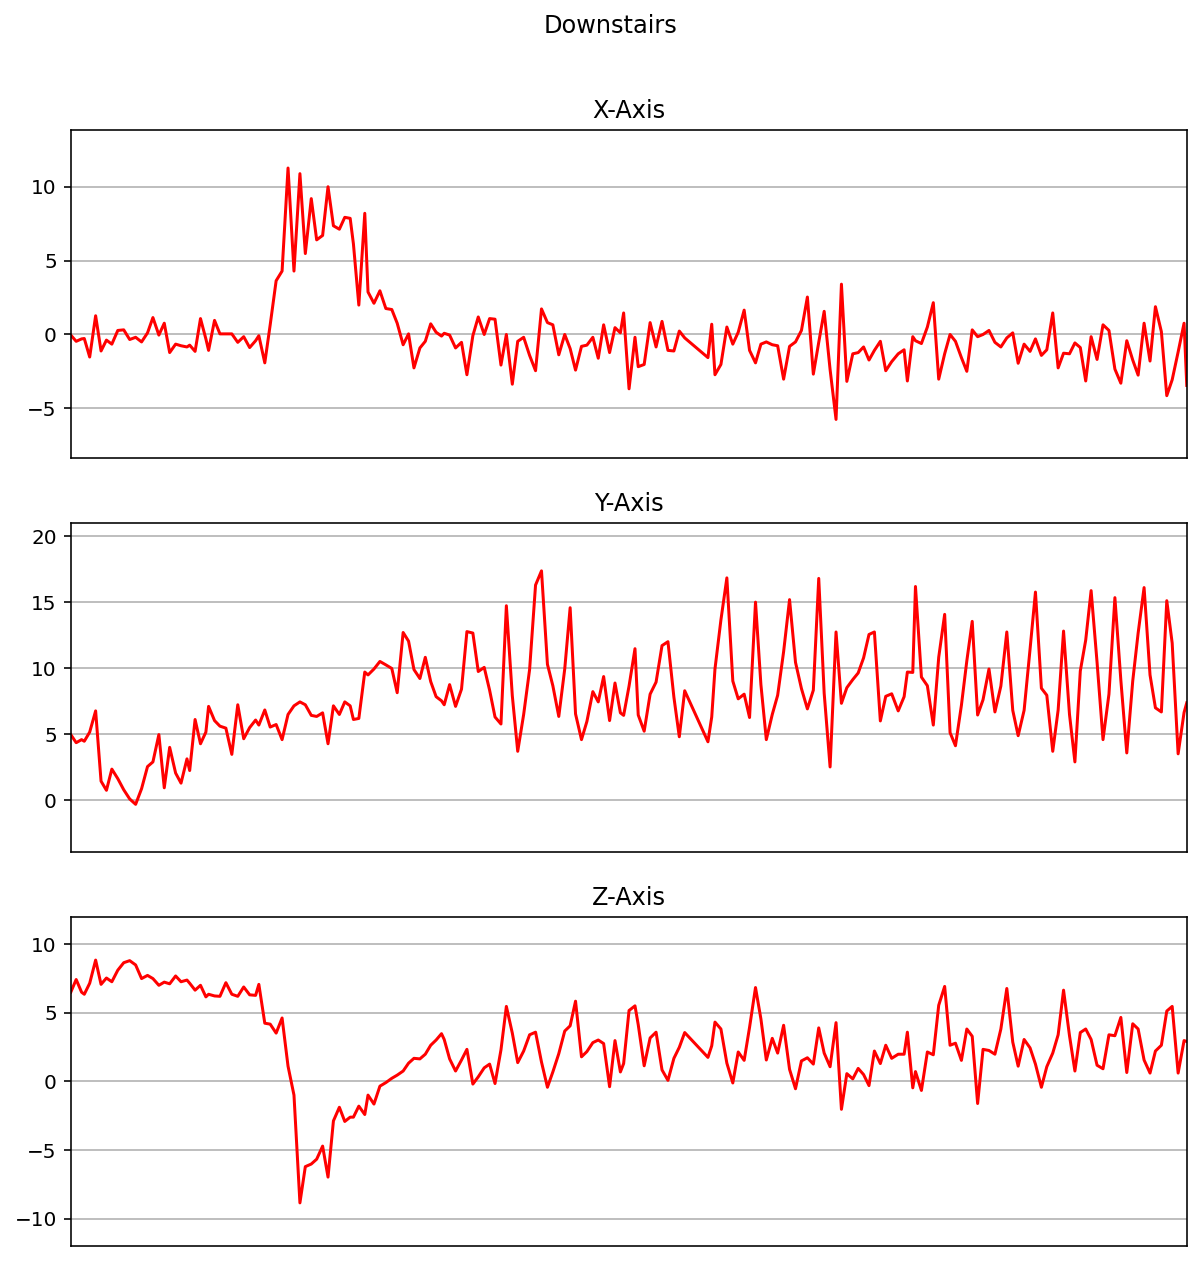

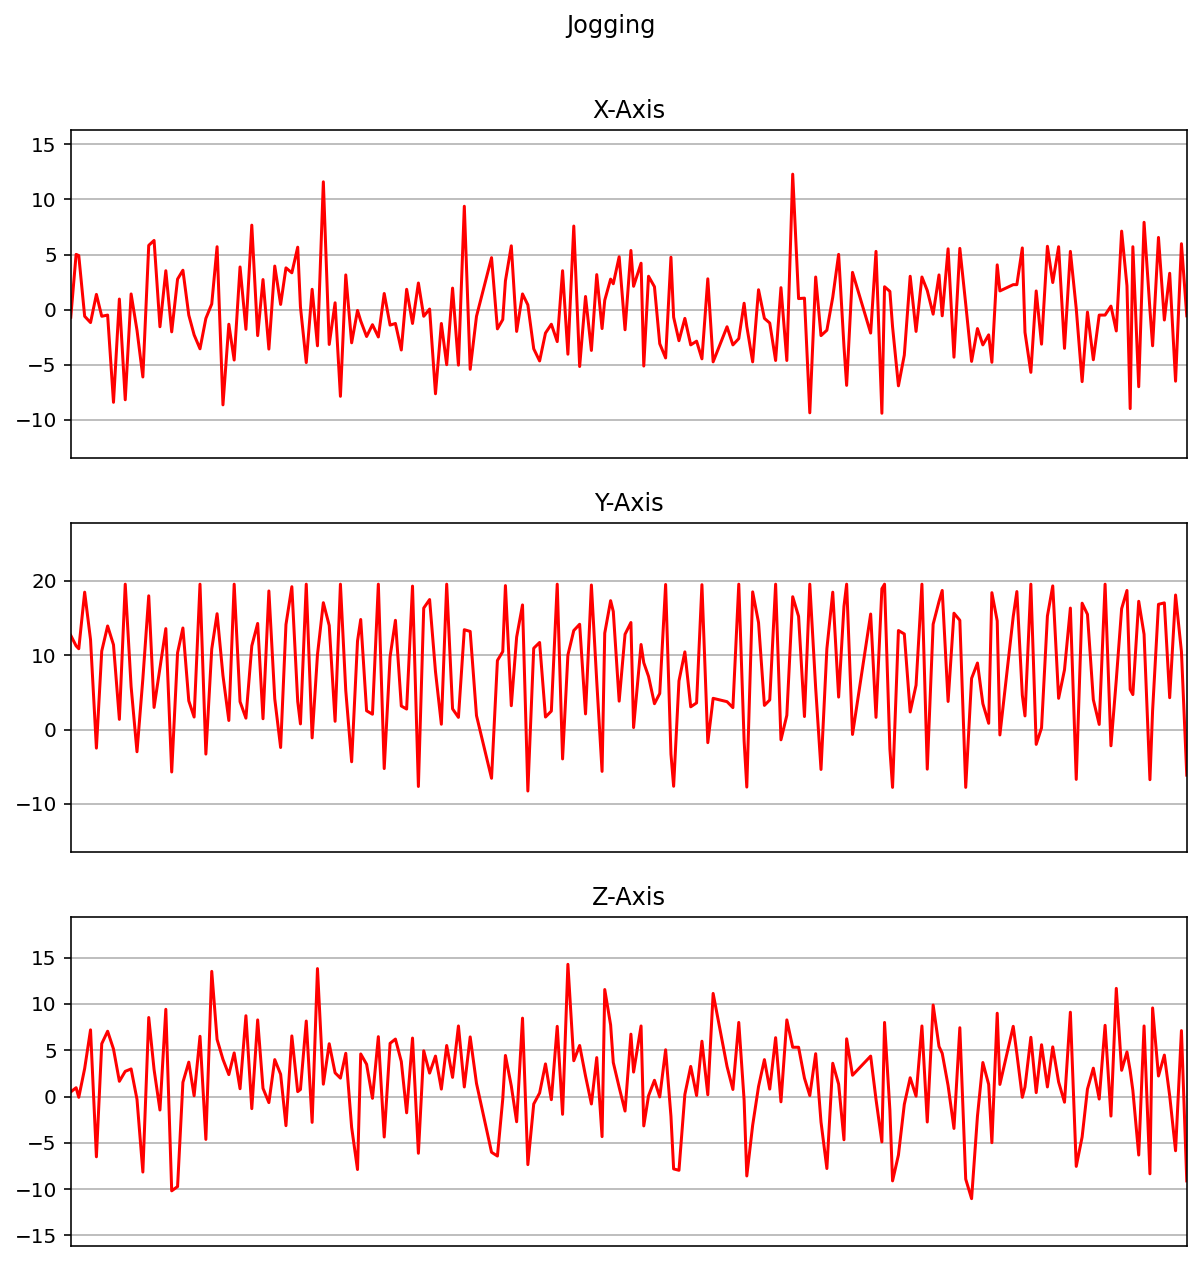

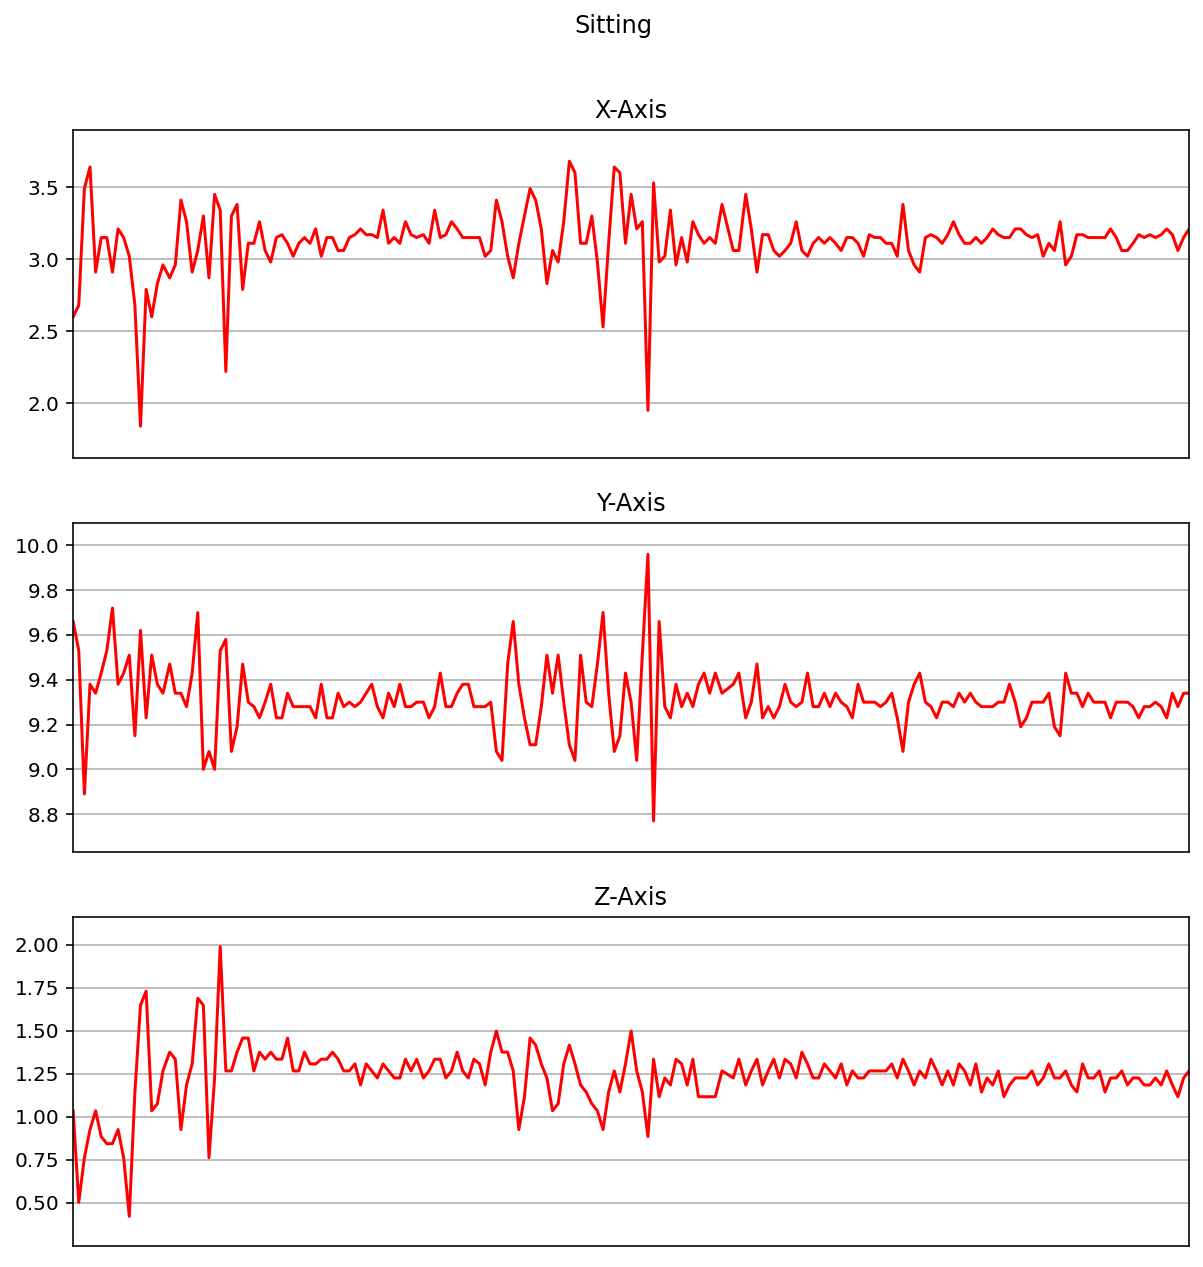

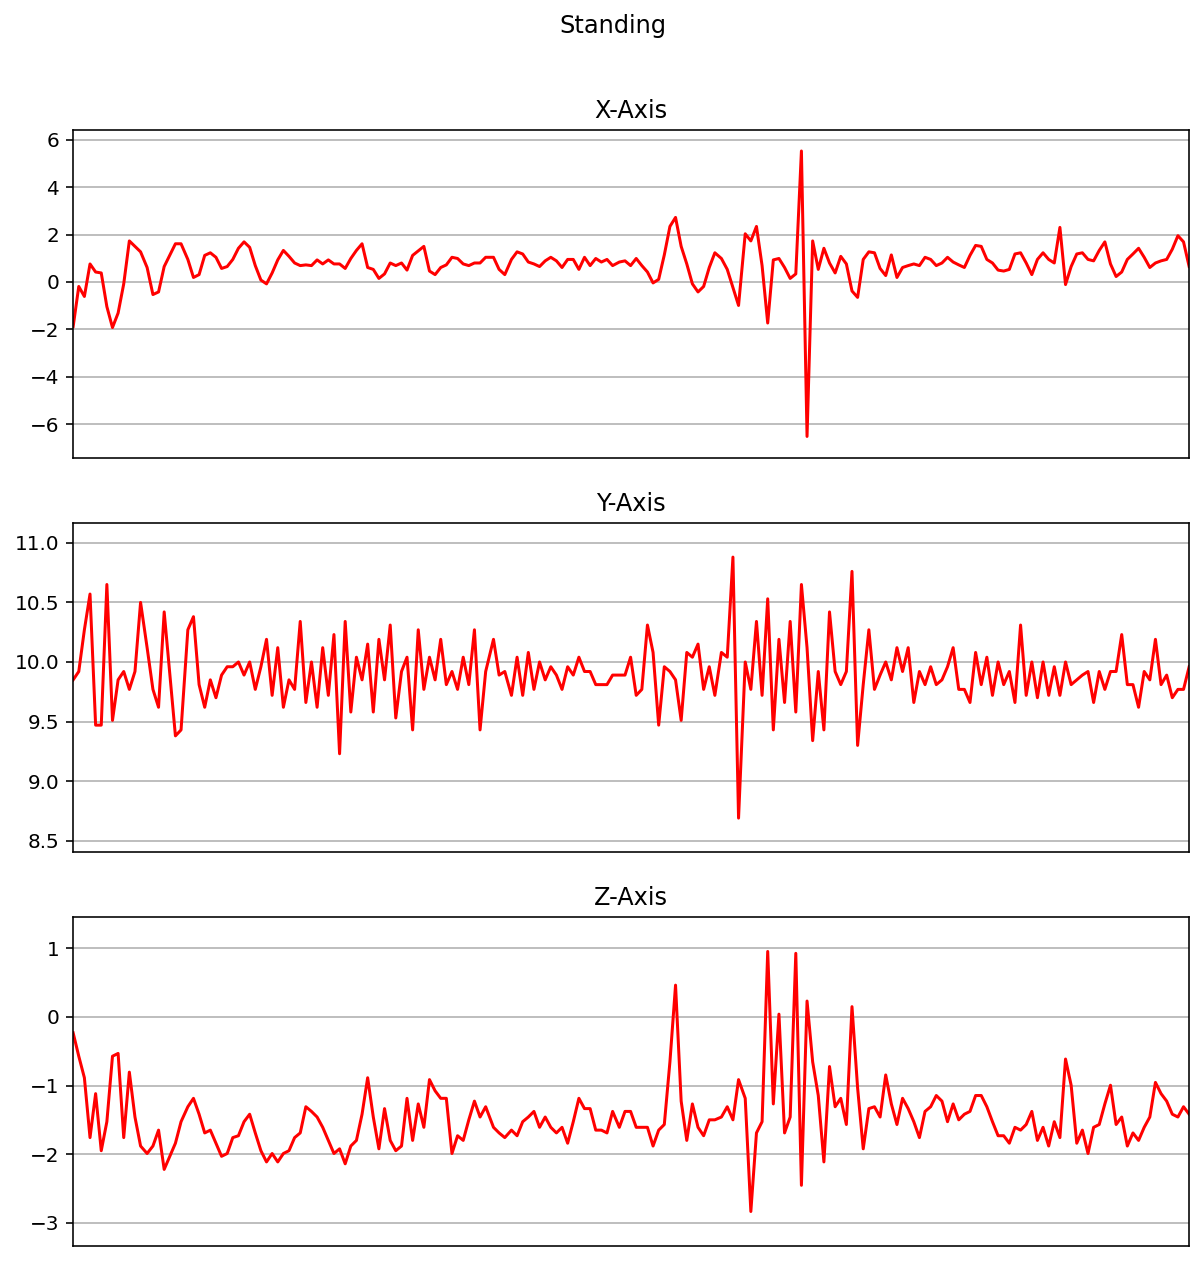

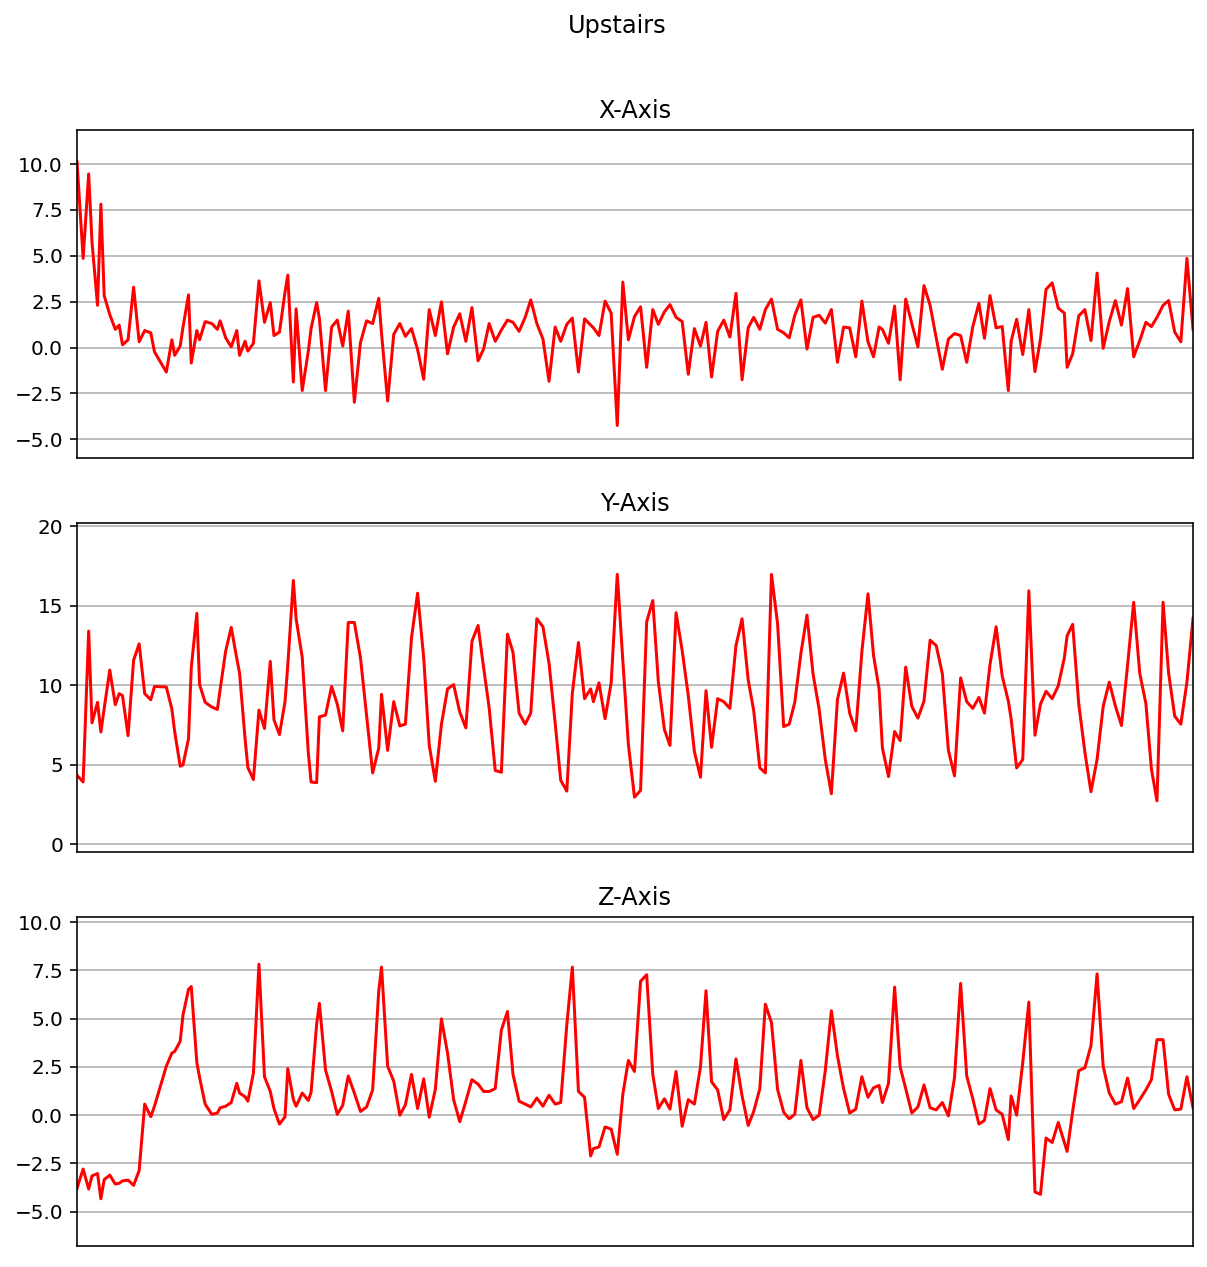

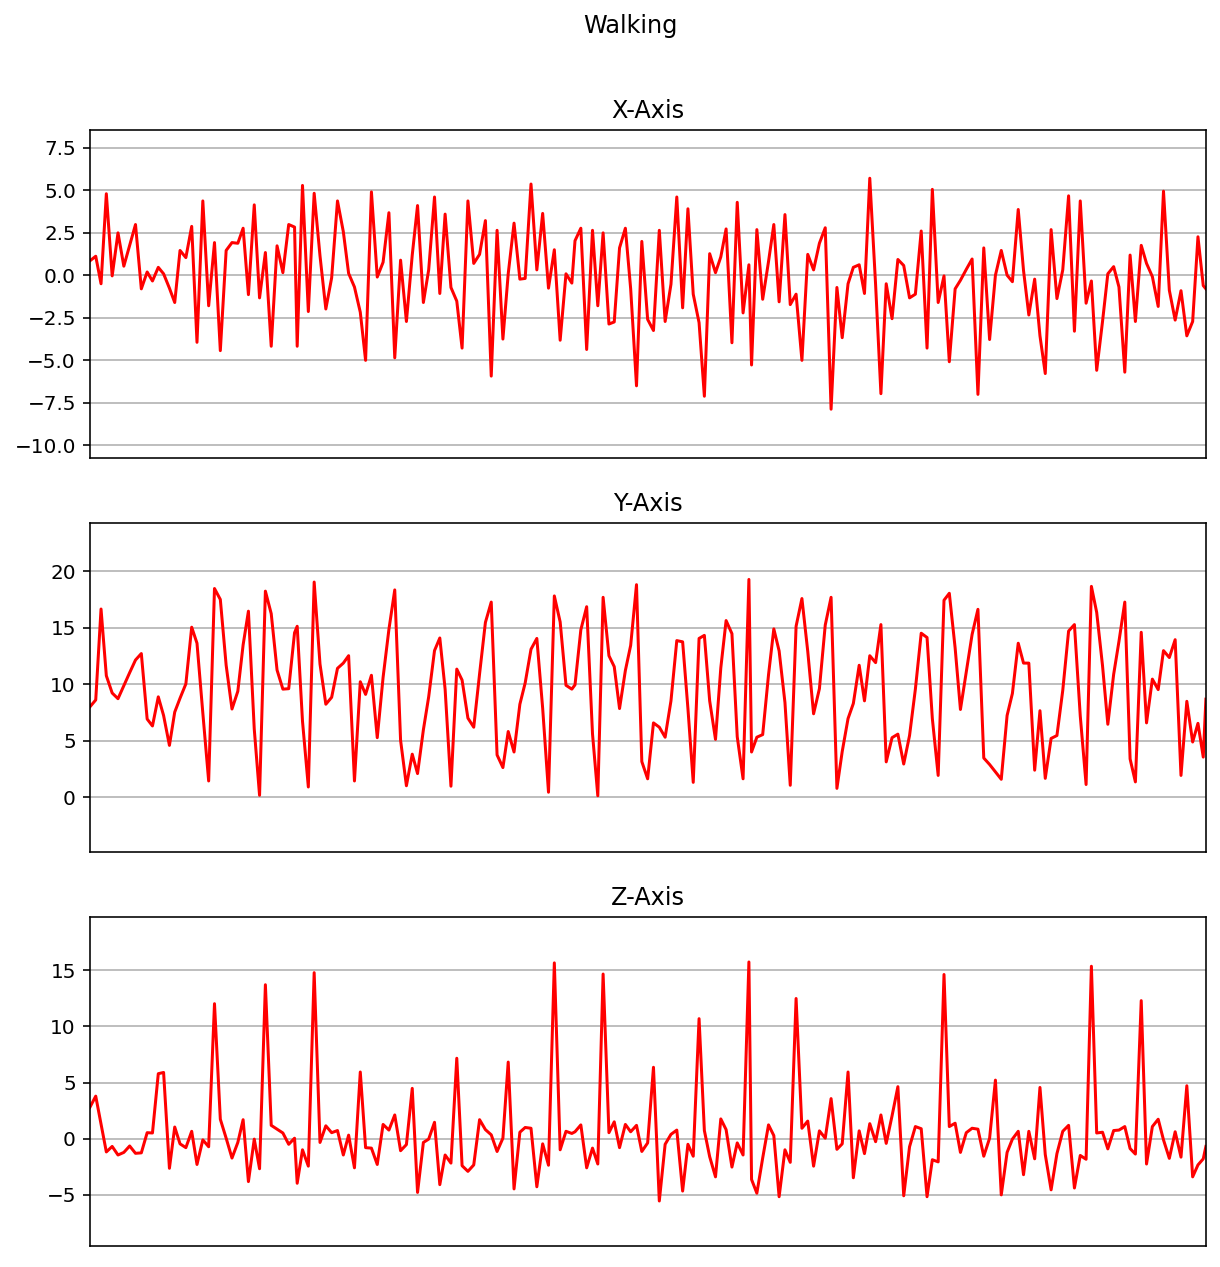

In [28]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(10,10), sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:200]
    plot_activity(activity, subset)

# **PreProcessing**

In [36]:
#LabelEncoder : 문자를 숫자로 다루기 위해서 문자를 0부터 시작하는 정수형 숫자로 바꿔줌 
le = preprocessing.LabelEncoder()
df['act'] = le.fit_transform(df['activity'].values)

In [37]:
#classes_ : 인코더에 등록된 클래스 조회 
le.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [38]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


In [39]:
test = [3,3,3,3,3,3,3,3,3,3,3,4,4,4,4,4]
m = stats.mode(test) # 최빈값
m

ModeResult(mode=array([3]), count=array([11]))

In [40]:
z = stats.mode(df['act'][1500:1600]) # 5초간 관찰
z[0][0], z[1][0]

(4, 100)

In [41]:
sc = preprocessing.StandardScaler()
df[['x-axis', 'y-axis', 'z-axis']] = sc.fit_transform(df[['x-axis', 'y-axis', 'z-axis']])

In [42]:
df[:5]

,user-id,activity,timestamp,x-axis,y-axis,z-axis,act
0,33,Jogging,49105962326000,-0.198190,0.792216,0.018408,1
1,33,Jogging,49106062271000,0.630212,0.582032,0.112401,1
2,33,Jogging,49106112167000,0.614395,0.525444,-0.104069,1
3,33,Jogging,49106222305000,-0.186327,1.655184,0.545341,1
4,33,Jogging,49106332290000,-0.269365,0.707334,1.419766,1


# **Split Train data & Test data**

사람을 기준으로 train, test 데이터 나눔  --- (1)

아예 랜덤하게 나누는 것과 매우 다르다. --- (2)

성능 (1) < (2)

일반성 (1) > (2)

In [44]:
(df['user-id'] < 28).mean()

0.7410978845728606

In [45]:
(df['user-id'] >= 28).mean()

0.25890211542713937

In [46]:
df_train = df[df['user-id'] < 28]
df_test = df[df['user-id'] >= 28]

In [47]:
df["z-axis"].isnull().sum()

0

In [48]:
def get_xy(N, df): # N  윈도우 크기 (100)
    X, y = [], []
    for i in range(0, len(df)-N+1, N):
        z = stats.mode(df['act'][i: i+N])
        action, count = z[0][0], z[1][0]
        if count == N:
            xs = df['x-axis'].values[i: i + N]
            ys = df['y-axis'].values[i: i + N]
            zs = df['z-axis'].values[i: i + N]
            X.append([xs, ys, zs])
            y.append(action)
    return np.transpose(X, (0,2,1)), np.array(y)

In [49]:
p = np.arange(24).reshape(2,3,4); np.transpose(p, (0,2,1))

array([[[ 0,  4,  8],
        [ 1,  5,  9],
        [ 2,  6, 10],
        [ 3,  7, 11]],

       [[12, 16, 20],
        [13, 17, 21],
        [14, 18, 22],
        [15, 19, 23]]])

In [50]:
N = 100
X_train, y_train = get_xy(N, df_train)

#feature x,y,x 3개 존재하므로 depth = 3, 입체적. 

In [51]:
X_test, y_test = get_xy(N, df_test)

In [52]:
X_train.shape, X_test.shape 
#차례로 sample수, data shape, feature 수

((7752, 100, 3), (2713, 100, 3))

In [53]:
y_train.shape, y_test.shape

((7752,), (2713,))

In [54]:
# 훈련 데이터를 축소하여 빨리 실행해 보는 방법
X2 = X_train[:1000,:,[0,1]] # 훈련 데이터를 간단히, x, y 축 값만 사용
X2.shape

(1000, 100, 2)

In [55]:
X_train.shape

(7752, 100, 3)

In [56]:
y_train #label encoding해서 숫자로. 

array([5, 5, 5, ..., 2, 2, 2])

In [57]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_train[:3]

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

# **RANDOM FOREST**

In [58]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
%matplotlib inline

In [59]:
# X_train, X_test, y_train, y_test = train_test_split(X, y)

rfc = RandomForestClassifier(n_estimators=100) 
rfc.fit(X_train.reshape(-1,300), y_train) #reshape에 -1 사용하는 이유? -1이 들어가 있는 곳의 개수가 가변적으로 정해짐 
rfc.score(X_test.reshape(-1,300), y_test)

0.6232952451161077

# **MLP (다층 퍼셉트론)**

In [61]:
model_m = Sequential()
model_m.add(Reshape((N*3,),input_shape=(N,3)))
model_m.add(Dense(100, activation='relu',input_shape=(N*3,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(6, activation='softmax'))
model_m.summary()

#은닉층 네개 추가. 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               30100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 6)                 606       
                                                                 
Total params: 50,906
Trainable params: 50,906
Non-trainable params: 0
_________________________________________________________________


In [62]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

h = model_m.fit(X_train,
                      y_train,
                      batch_size=10,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=0)

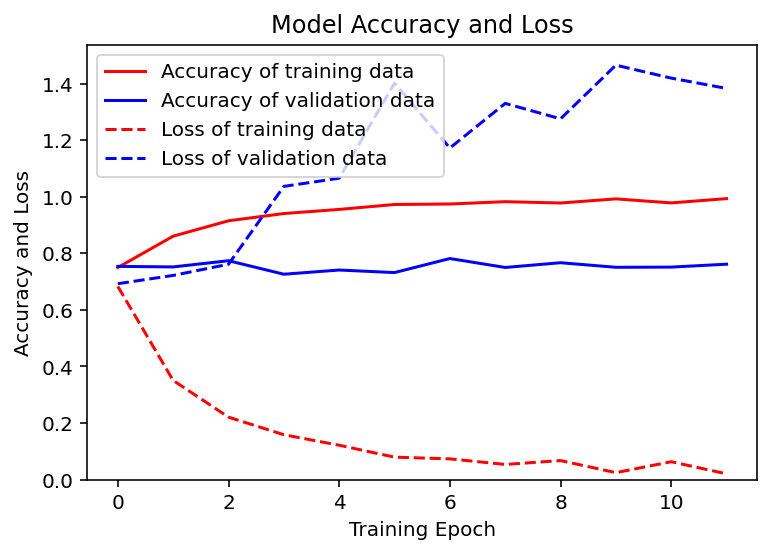

In [63]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()
    
show_4_graphs(h)

In [64]:
def show_confusion_matrix(validations, predictions):
    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

85/85 [==============================] - 1s 6ms/step


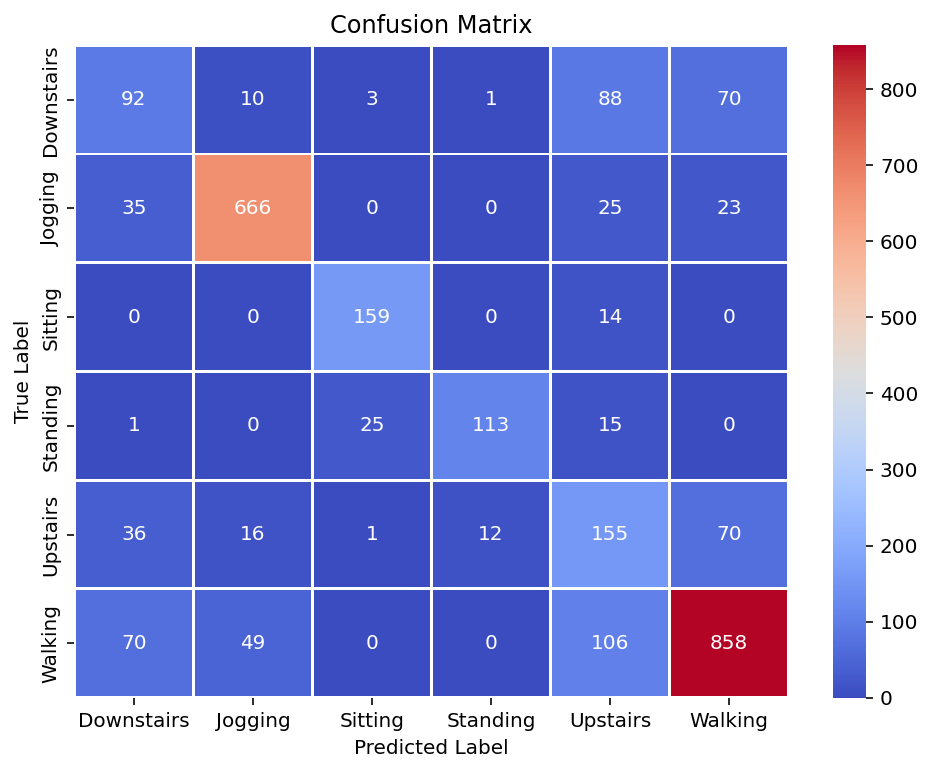

              precision    recall  f1-score   support

           0       0.39      0.35      0.37       264
           1       0.90      0.89      0.89       749
           2       0.85      0.92      0.88       173
           3       0.90      0.73      0.81       154
           4       0.38      0.53      0.45       290
           5       0.84      0.79      0.82      1083

    accuracy                           0.75      2713
   macro avg       0.71      0.70      0.70      2713
weighted avg       0.77      0.75      0.76      2713



In [65]:
def show_results(y_test, y_pred):
    max_y_pred_test = np.argmax(y_pred, axis=1)
    max_y_test = np.argmax(y_test, axis=1)
    show_confusion_matrix(max_y_test, max_y_pred_test)
    print(classification_report(max_y_test, max_y_pred_test))
    
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

# **CNN**

In [66]:
model_m = Sequential()
model_m.add(Conv1D(64, 2, activation='relu',input_shape=(N,3)))
model_m.add(Conv1D(64, 4, activation='relu'))
model_m.add(MaxPooling1D(3))
model_m.add(Conv1D(128, 10, activation='relu'))
model_m.add(GlobalAveragePooling1D())
# model_m.add(MaxPooling1D(3))
# model_m.add(Flatten())
model_m.add(Dropout(0.3))
model_m.add(Dense(6, activation='softmax'))
print(model_m.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 99, 64)            448       
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 64)            16448     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 64)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 23, 128)           82048     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 128)              

In [67]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
]
##EarlyStopping : metric에 개선이 없을 때, 학습을 중단할 수 있는 콜백 

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

history = model_m.fit(X_train,
                      y_train,
                      batch_size=20,
                      epochs=30,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Epoch 1/30
311/311 [==============================] - 15s 38ms/step - loss: 0.6334 - accuracy: 0.7621 - val_loss: 0.7503 - val_accuracy: 0.7834
Epoch 2/30
311/311 [==============================] - 7s 22ms/step - loss: 0.2678 - accuracy: 0.9032 - val_loss: 0.9266 - val_accuracy: 0.7427
Epoch 3/30
311/311 [==============================] - 7s 22ms/step - loss: 0.1779 - accuracy: 0.9376 - val_loss: 0.8882 - val_accuracy: 0.7801
Epoch 4/30
311/311 [==============================] - 7s 22ms/step - loss: 0.1281 - accuracy: 0.9565 - val_loss: 0.9561 - val_accuracy: 0.7718
Epoch 5/30
311/311 [==============================] - 8s 25ms/step - loss: 0.1044 - accuracy: 0.9653 - val_loss: 1.1874 - val_accuracy: 0.7602
Epoch 6/30
311/311 [==============================] - 10s 32ms/step - loss: 0.0977 - accuracy: 0.9689 - val_loss: 1.1079 - val_accuracy: 0.7531


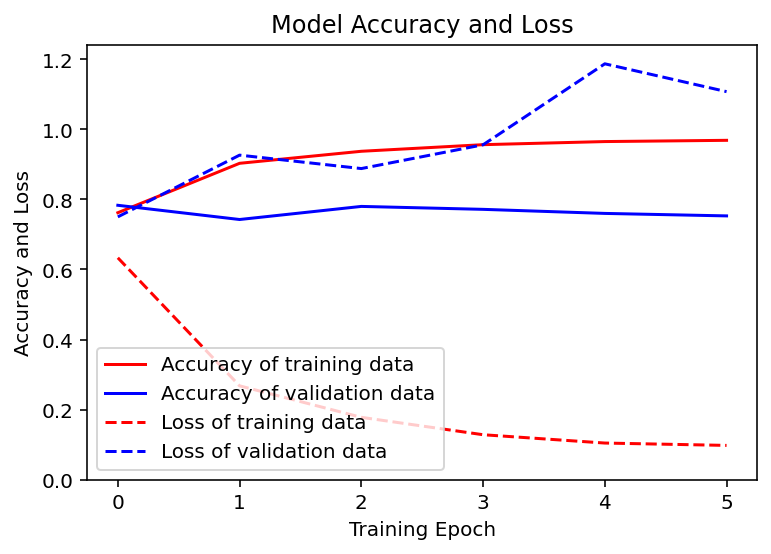

In [68]:
show_4_graphs(history)

85/85 [==============================] - 1s 9ms/step


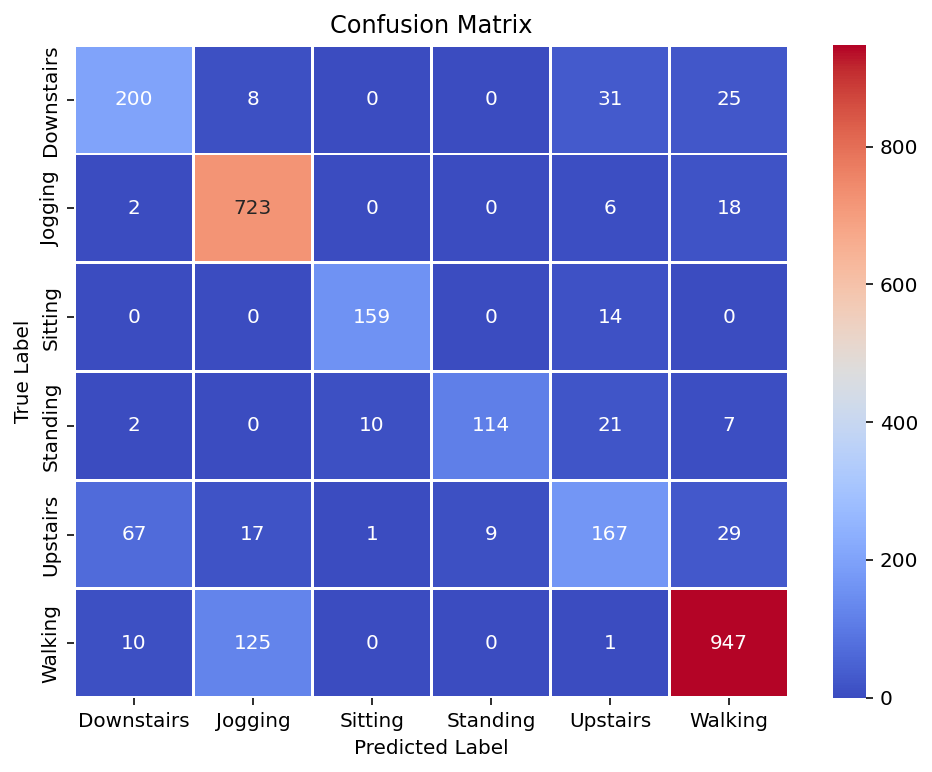

              precision    recall  f1-score   support

           0       0.71      0.76      0.73       264
           1       0.83      0.97      0.89       749
           2       0.94      0.92      0.93       173
           3       0.93      0.74      0.82       154
           4       0.70      0.58      0.63       290
           5       0.92      0.87      0.90      1083

    accuracy                           0.85      2713
   macro avg       0.84      0.81      0.82      2713
weighted avg       0.85      0.85      0.85      2713



In [69]:
y_pred = model_m.predict(X_test)
show_results(y_test, y_pred)

RNN?

시계열 예측에는 RNN이 우수하나 패턴 찾기에는 CNN이 더 좋음.